# DSI Project 4: West Nile Virus Prediction
------
*by Esther, Pratch, Wayne (DSI-16)*

# Recap on Problem Statement 

Due to a recent outbreak of the West Nile Virus in the city of Chicago, our Data Science team at the Disease and Treatment Agency has been tasked by the Centers for Disease Control (CDC) to develop a strategy to deploy the effective use of pesticides, by targeting spraying of pesticides to areas of high risk will help to mitigate future outbreaks.

Leveraging on weather, location, mosquito population and spraying data, the team will develop a **binary classification model to predict the presence of the West Nile Virus** in the city of Chicago. 

The model that achieves the **highest ROC AUC score** and **Sensitivity** on the validation data set, will be selected as our production model. 

High ROC AUC score means that our model has strong discrimination capacity to distinguish between positive class and negative class. Our **baseline ROC AUC score will be 0.5**, which means that the model has no discrimination capacity to distinguish between the 2 classes.

To mitigate the risk of future outbreaks, we want to be as accurate as possible at predicting the presence of West Nile Virus (positive class).  Hence, we will focus more on the **Sensitivity Score** (True Positives / (True Positive + False Negative)).  There is a higher risk of outbreaks if the model predicts an absence where the virus is present (False Negative), whereas it is just overcaution if the model wrongly predicts a presence of the virus (False Positive).

# Part 2:  Modelling & Evaluation

In this second part of the project, we will focus on building several classification models, and comparing the model performance.

* [1. Loading Data](#1.-Loading-Data)
* [2. Modelling Objectives](#2.-Modelling-Objectives)
* [3. Model Preparation](#3.-Model-Preparation)
* [4. Modelling](#4.-Modelling)
* [5. Model Evaluation](#5.-Model-Evaluation)
* [6. Generate Predictions](#6.-Generate-Predictions)
* [7. Cost Benefit Analysis](#7.-Cost-Benefit-Analysis)
* [8. Conclusion & Recommendation](#8.-Conclusion-and-Recommendation)

For our data cleaning, EDA and feature engineering prior to Modelling, please refer to our jupyter notbook **P4_1_Data_Cleaning_and_EDA**.

# 1. Loading Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_auc_score , plot_roc_curve

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

plt.style.use('seaborn-muted')
sns.set_style(style='white')

%matplotlib inline

In [2]:
# load datasets 
train = pd.read_csv('./data/train_cleaned.csv', parse_dates=['Date'])
test = pd.read_csv('./data/test_cleaned.csv', parse_dates=['Date'])

### Train Dataset 
- This is the new train data set that is cleaned and merged with selected features from weather dataset post feature-engineering.
- This file contains the columns 'NumMosquitos' and 'WnvPresent' to train the model for predictions, and do not have the column 'Id' in test dataset that will be used for submitting predictions.

In [3]:
train.head()

,Date,Latitude,Longitude,NumMosquitos,WnvPresent,Month,Year,C_Pipiens,C_Pipiens/Restuans,C_Restuans,C_Salinarius,C_Tarsalis,C_Territans,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Station,Tavg,PrecipTotal,StnPressure,AvgSpeed,Tavg_rolling4_shift7,PrecipTotal_rolling4_shift7,StnPressure_rolling4_shift7,AvgSpeed_rolling4_shift7,Opt_temp
0,2007-05-29,41.731922,-87.677512,1,0,5,2007,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,77.0,0.0,29.44,7.4,65.5,0.0275,29.4125,9.875,1.0
1,2007-05-29,41.867108,-87.654224,1,0,5,2007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,77.0,0.0,29.44,7.4,65.5,0.0275,29.4125,9.875,1.0
2,2007-05-29,41.919343,-87.694259,1,0,5,2007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,77.0,0.0,29.44,7.4,65.5,0.0275,29.4125,9.875,1.0
3,2007-05-29,41.921965,-87.632085,2,0,5,2007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,77.0,0.0,29.44,7.4,65.5,0.0275,29.4125,9.875,1.0
4,2007-05-29,41.688324,-87.676709,1,0,5,2007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,77.0,0.0,29.44,7.4,65.5,0.0275,29.4125,9.875,1.0


In [4]:
train.shape

(8475, 158)

For modelling, we will be using all the columns except Date, Station, and NumMosquitos. Let's drop these columns first.

In [5]:
train.drop(columns=['Date', 'Station', 'NumMosquitos'], inplace=True)

In [6]:
len(train.columns)

155

### Test Data Set 
- This is the new train data set that is cleaned and merged with selected features from weather dataset post feature-engineering.
- Test data does not have target variable 'WnvPresent' for prediction, as well as the related column 'NumMosquitos'
- The column 'Id' will be used for submission together with the predictions of the target variable 'WnvPresent'

In [7]:
test.head()

,Id,Date,Latitude,Longitude,Month,Year,C_Pipiens,C_Pipiens/Restuans,C_Restuans,C_Salinarius,C_Tarsalis,C_Territans,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Station,Tavg,PrecipTotal,StnPressure,AvgSpeed,Tavg_rolling4_shift7,PrecipTotal_rolling4_shift7,StnPressure_rolling4_shift7,AvgSpeed_rolling4_shift7,Opt_temp
0,1,2008-06-11,41.95469,-87.800991,6,2008,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,74.0,0.0,29.28,10.0,65.75,0.1325,29.065,6.15,1.0
1,2,2008-06-11,41.95469,-87.800991,6,2008,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,74.0,0.0,29.28,10.0,65.75,0.1325,29.065,6.15,1.0
2,3,2008-06-11,41.95469,-87.800991,6,2008,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,74.0,0.0,29.28,10.0,65.75,0.1325,29.065,6.15,1.0
3,4,2008-06-11,41.95469,-87.800991,6,2008,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,74.0,0.0,29.28,10.0,65.75,0.1325,29.065,6.15,1.0
4,5,2008-06-11,41.95469,-87.800991,6,2008,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,74.0,0.0,29.28,10.0,65.75,0.1325,29.065,6.15,1.0


In [8]:
test.shape

(116293, 157)

Similarly, for the test data, we will also drop Date and Station.

In [9]:
test.drop(columns=['Date', 'Station'], inplace=True)

In [10]:
len(test.columns)

155

# 2. Modelling Objectives

* Model should handle imbalanced dataset shown below (positive class: 5.4%)
* Model selected for production should have the highest ROC AUC score and Sensitivity.

In [11]:
train['WnvPresent'].value_counts(normalize=True)

0    0.946077
1    0.053923
Name: WnvPresent, dtype: float64

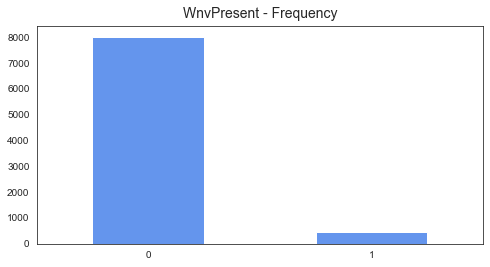

In [12]:
plt.figure(figsize=(12,6))
train['WnvPresent'].value_counts().plot(kind='bar', color='cornflowerblue', figsize=(8, 4))
plt.title('WnvPresent - Frequency', fontsize = 14, y=1.01)
plt.xticks(rotation=0);

# 3. Model Preparation

In [13]:
# set up X and y
X = train[[col for col in train.columns if col != 'WnvPresent']]
y = train['WnvPresent']

In [14]:
X.shape

(8475, 154)

In [15]:
y.shape

(8475,)

In [16]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
X_train.shape

(6780, 154)

In [18]:
X_val.shape

(1695, 154)

In [19]:
y_val.value_counts(normalize=True)

0    0.946313
1    0.053687
Name: WnvPresent, dtype: float64

### Resampling for Imbalanced Dataset using SMOTE

To handle the imbalanced dataset, we can apply SMOTE for oversampling. 

Let's visualise the data distribution of the imbalanced dataset, and see how SMOTE changes the data distribution.

In [20]:
# Define function for 2-dimensional plot to visualise data distribution
def plot_2d_space(X, y, label='Classes'):   
    colors = ['b', 'r']
    markers = ['o', 's']
    plt.figure(figsize=(10,5))
    for l, c, m in zip(np.unique(y), colors, markers):
            plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            alpha = 0.5,
            c=c, label=l, marker=m
        )
    plt.title(label, fontsize=14, y=1.01)
    leg = plt.legend(loc='upper right')
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.show()

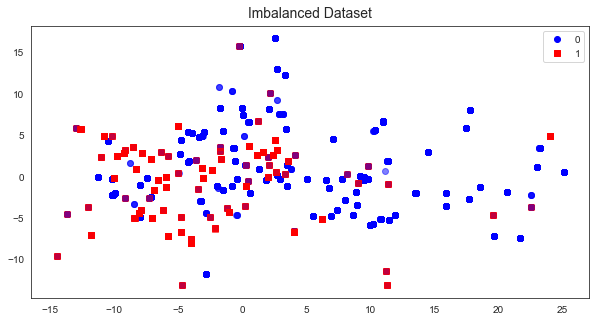

In [21]:
# Because the dataset has many dimensions (features) and our graphs will be 2D,
# we will reduce the size of the dataset using PCA

pca = PCA(n_components=2)
X_imbalanced = pca.fit_transform(X)

plot_2d_space(X_imbalanced, y, 'Imbalanced Dataset')

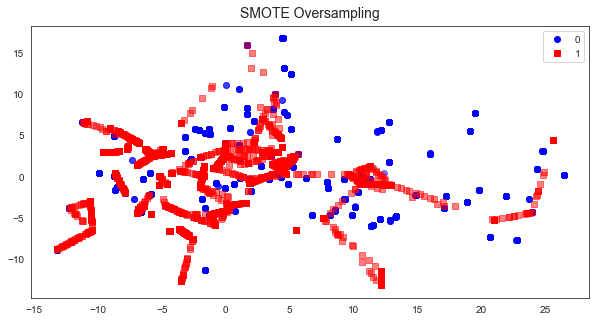

In [22]:
# visualising data distribution with SMOTE Oversampling

pca = PCA(n_components=2)
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_sample(X, y)
X_balanced = pca.fit_transform(X_sm)

plot_2d_space(X_balanced, y_sm, 'SMOTE Oversampling')

By applying SMOTE, we synthesize elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [23]:
y_sm.value_counts(normalize=True)

1    0.5
0    0.5
Name: WnvPresent, dtype: float64

With oversampling using SMOTE, the baseline accuracy is now 0.5.

We will **include SMOTE in models which does not handle imbalanced class internally**.

# 4. Modelling

## Model 1: Logistic Regression (with SMOTE)

In [24]:
# set up pipeline
pipe_lr = make_pipeline(StandardScaler(),
                        SMOTE(random_state=42),
                        LogisticRegression(solver='lbfgs',random_state=42, max_iter=1000))

In [25]:
kf = KFold(n_splits=5, shuffle=False)

In [26]:
# cross validation score (roc auc)
cross_val_score(pipe_lr, X_train, y_train, scoring='roc_auc', cv=kf).mean()

0.7654464782803875

In [27]:
pipe_lr.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('smote', SMOTE(random_state=42)),
  ('logisticregression', LogisticRegression(max_iter=1000, random_state=42))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'smote': SMOTE(random_state=42),
 'logisticregression': LogisticRegression(max_iter=1000, random_state=42),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': 42,
 'smote__sampling_strategy': 'auto',
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 1000,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': 42,

In [28]:
# for hyperparameter tuning
pipe_lr_params = {
    'logisticregression__C': [0.01, 0.1, 1.0],
    'logisticregression__max_iter': [1000, 1500, 2000]
}

In [29]:
gs_lr = GridSearchCV(pipe_lr, param_grid=pipe_lr_params, cv=kf, 
                     scoring='roc_auc', return_train_score=True)

In [30]:
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1.0],
                         'logisticregression__max_iter': [1000, 1500, 2000]},
             return_train_score=True, scoring='roc_auc')

In [31]:
gs_lr.best_params_

{'logisticregression__C': 0.01, 'logisticregression__max_iter': 1000}

In [32]:
gs_lr.best_score_

0.7801666342834946

In [33]:
gs_lr_model = gs_lr.best_estimator_

In [34]:
gs_lr_y_preds = gs_lr_model.predict(X_val)

In [35]:
# define function for model evaluation
def model_eval(model_name, model, X_test, y_test, y_preds):
    """function to generate classification report,
    plot confusion matrix and ROC curve"""
    print(f"Model           : {model_name}")
    print('----------------------------------------------------------------')
    print(classification_report(y_test, y_preds))
    print(f"train roc auc      {model.best_score_:.2f}")
    plot_confusion_matrix(model.best_estimator_, X_test, y_test, cmap='Blues', values_format='d');
    plot_roc_curve(model.best_estimator_, X_test, y_test);

Model           : Logistic Regression
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1604
           1       0.15      0.68      0.24        91

    accuracy                           0.77      1695
   macro avg       0.56      0.73      0.55      1695
weighted avg       0.93      0.77      0.83      1695

train roc auc      0.78


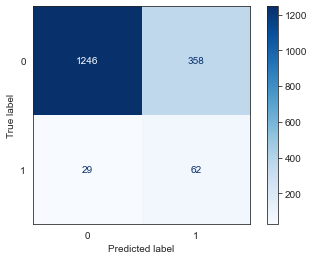

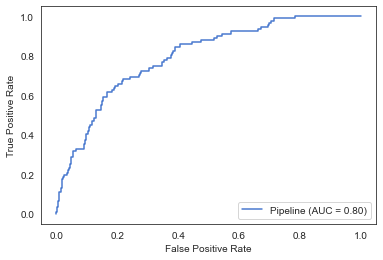

In [36]:
model_eval('Logistic Regression', gs_lr, X_val, y_val, gs_lr_y_preds)

The **Logistic Regression Model (with SMOTE) model** has a **Validation ROC AUC of 0.80**.

While the Accuracy is 0.77, the **Sensitivity (recall) is only 0.68**.

In [37]:
lr_coef = pd.Series(np.exp(gs_lr_model.named_steps['logisticregression'].coef_[0]), 
                    index = X_train.columns)

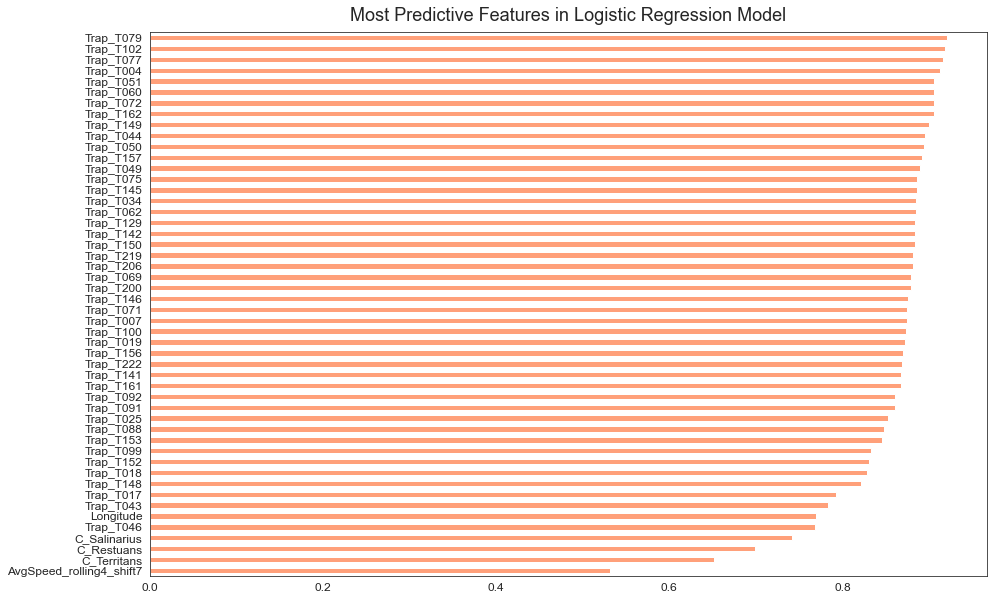

In [38]:
lr_coef.sort_values(ascending=True).head(50).plot(kind='barh', color='lightsalmon', figsize=(15,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Most Predictive Features in Logistic Regression Model', fontsize=18, y=1.01);

**Location based on trap number** is the most predictive feature in the Logistic Regression (with SMOTE) model.

## Model 2: Random Forest (with Class Weighting)

When using Random Forest, we can apply [class weighting](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/) to handle imbalanced class (instead of using SMOTE). 

In [39]:
# set up pipeline for random forest
# scaling is not needed for decision trees
pipe_rf = make_pipeline(RandomForestClassifier(class_weight='balanced', random_state=42))

In [40]:
# cross validation score (roc auc)
cross_val_score(pipe_rf, X_train, y_train, scoring='roc_auc', cv=kf).mean()

0.821750503756965

In [41]:
pipe_rf.get_params()

{'memory': None,
 'steps': [('randomforestclassifier',
   RandomForestClassifier(class_weight='balanced', random_state=42))],
 'verbose': False,
 'randomforestclassifier': RandomForestClassifier(class_weight='balanced', random_state=42),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_impurity_split': None,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__n_jobs': None,
 'randomforestclassifier__oob_score': 

In [42]:
# for hyperparameter tuning
pipe_rf_params = {
    'randomforestclassifier__max_depth': [2,3,4],
    'randomforestclassifier__n_estimators': [100, 150, 200]
}

In [43]:
gs_rf = GridSearchCV(pipe_rf, param_grid=pipe_rf_params, cv=kf, 
                     scoring='roc_auc', return_train_score=True)

In [44]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': [2, 3, 4],
                         'randomforestclassifier__n_estimators': [100, 150,
                                                                  200]},
             return_train_score=True, scoring='roc_auc')

In [45]:
gs_rf.best_params_

{'randomforestclassifier__max_depth': 4,
 'randomforestclassifier__n_estimators': 200}

In [46]:
gs_rf.best_score_

0.831622081501234

In [47]:
gs_rf_model = gs_rf.best_estimator_

In [48]:
gs_rf_y_preds = gs_rf_model.predict(X_val)

Model           : Random Forest
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.74      0.85      1604
           1       0.15      0.77      0.24        91

    accuracy                           0.75      1695
   macro avg       0.56      0.76      0.55      1695
weighted avg       0.94      0.75      0.81      1695

train roc auc      0.83


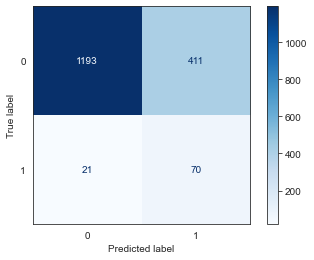

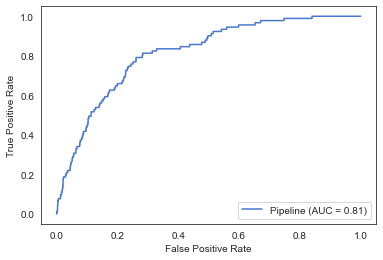

In [49]:
model_eval('Random Forest', gs_rf, X_val, y_val, gs_rf_y_preds)

For the **Random Forest (with Class Weighting) model**, we achieve a **higher Validation ROC AUC score of 0.81**. The model's Accuracy is 0.75, and a **higher Sensitivity of 0.77** as compared to Logistic Regression.

Unlike Logistic Regression, we do not have a feature coefficient to indicate which feature is more predictive. Instead, we will use 'feature_importances_' in scikit-learn to see which feature contributes more to decreasing the weighted impurity ([source](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e))

In [50]:
rf_feature_impt = gs_rf_model.named_steps['randomforestclassifier'].feature_importances_
rf_feature_impt_df = pd.DataFrame(index=X_train.columns, data = rf_feature_impt, columns = ['feature importance'])

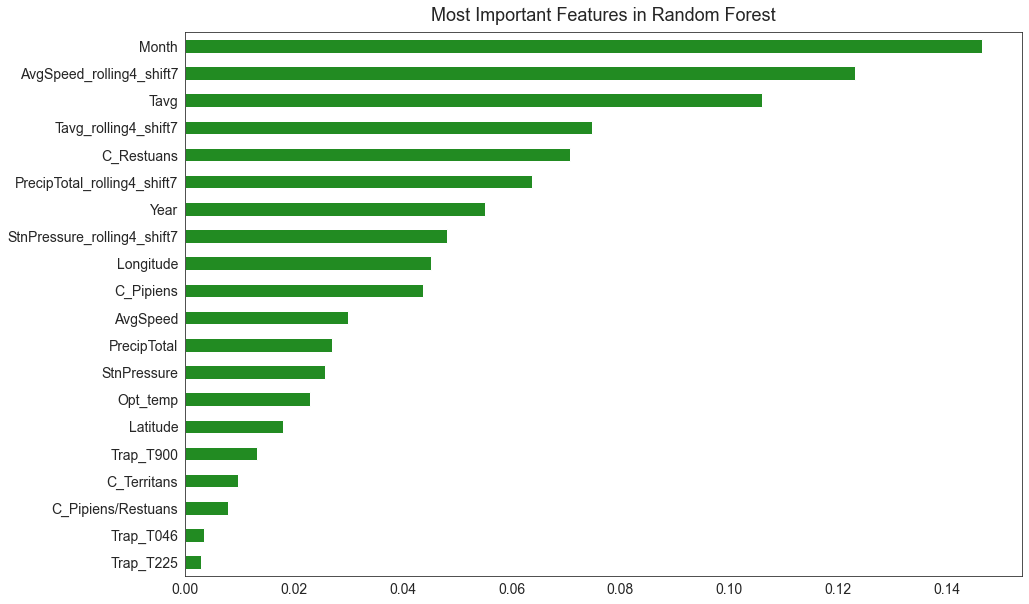

In [51]:
rf_feature_impt_df.sort_values(by='feature importance', ascending=True).tail(20).plot(kind='barh', color='forestgreen', legend = False, figsize=(15,10));
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Most Important Features in Random Forest', fontsize=18, y=1.01);

**Month** stands out as the most important feature in the Random Forest model. **Weather features such as AvgSpeed and Tavg of the mosquito breeding window** are also important features to predict WNV.

## Model 3: AdaBoost (with SMOTE) a.k.a. SMOTEBoost

We came across [article](https://medium.com/urbint-engineering/using-smoteboost-and-rusboost-to-deal-with-class-imbalance-c18f8bf5b805) that suggest that applying SMOTE before AdaBoost can help improve model performance for imbalanced data. Let's explore this approach.

In [52]:
# set up pipeline
pipe_ada = make_pipeline(SMOTE(random_state=42),
                         AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42))

In [53]:
# cross validation score (roc auc)
cross_val_score(pipe_ada, X_train, y_train, scoring='roc_auc', cv=kf).mean()

0.6190850330582345

In [54]:
pipe_ada.get_params()

{'memory': None,
 'steps': [('smote', SMOTE(random_state=42)),
  ('adaboostclassifier',
   AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42))],
 'verbose': False,
 'smote': SMOTE(random_state=42),
 'adaboostclassifier': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42),
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': 42,
 'smote__sampling_strategy': 'auto',
 'adaboostclassifier__algorithm': 'SAMME.R',
 'adaboostclassifier__base_estimator__ccp_alpha': 0.0,
 'adaboostclassifier__base_estimator__class_weight': None,
 'adaboostclassifier__base_estimator__criterion': 'gini',
 'adaboostclassifier__base_estimator__max_depth': None,
 'adaboostclassifier__base_estimator__max_features': None,
 'adaboostclassifier__base_estimator__max_leaf_nodes': None,
 'adaboostclassifier__base_estimator__min_impurity_decrease': 0.0,
 'adaboostclassifier__base_estimator__min_impurity_split': None,
 'adaboostclassifier__base_estimato

In [55]:
# for hyperparameter tuning
pipe_ada_params = {
    'adaboostclassifier__learning_rate': [0.9, 1.0],
    'adaboostclassifier__n_estimators': [50, 100],
    'adaboostclassifier__base_estimator__max_depth': [1, 2]
}

In [56]:
gs_ada = GridSearchCV(pipe_ada, param_grid=pipe_ada_params, cv=kf, 
                     scoring='roc_auc', return_train_score=True)

In [57]:
gs_ada.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                                           random_state=42))]),
             param_grid={'adaboostclassifier__base_estimator__max_depth': [1,
                                                                           2],
                         'adaboostclassifier__learning_rate': [0.9, 1.0],
                         'adaboostclassifier__n_estimators': [50, 100]},
             return_train_score=True, scoring='roc_auc')

In [58]:
gs_ada.best_params_

{'adaboostclassifier__base_estimator__max_depth': 1,
 'adaboostclassifier__learning_rate': 0.9,
 'adaboostclassifier__n_estimators': 50}

In [59]:
gs_ada.best_score_

0.8135399754367285

In [60]:
gs_ada_model = gs_ada.best_estimator_

In [61]:
gs_ada_y_preds = gs_ada_model.predict(X_val)

Model           : AdaBoost
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      1604
           1       0.15      0.56      0.24        91

    accuracy                           0.81      1695
   macro avg       0.56      0.69      0.57      1695
weighted avg       0.93      0.81      0.86      1695

train roc auc      0.81


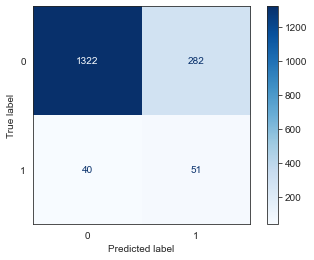

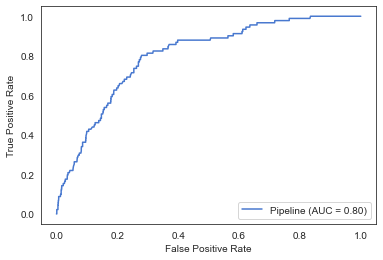

In [62]:
model_eval('AdaBoost', gs_ada, X_val, y_val, gs_ada_y_preds)

The **AdaBoost (with SMOTE) model** has a **Validation ROC AUC of 0.80**. While Accuracy is high at 0.81, **Sensitivity is low at 0.56**, which is not a good model based on our objectives.

In [63]:
ada_feature_impt = gs_ada_model.named_steps['adaboostclassifier'].feature_importances_
ada_feature_impt_df = pd.DataFrame(index=X_train.columns, data = ada_feature_impt, columns = ['feature importance'])

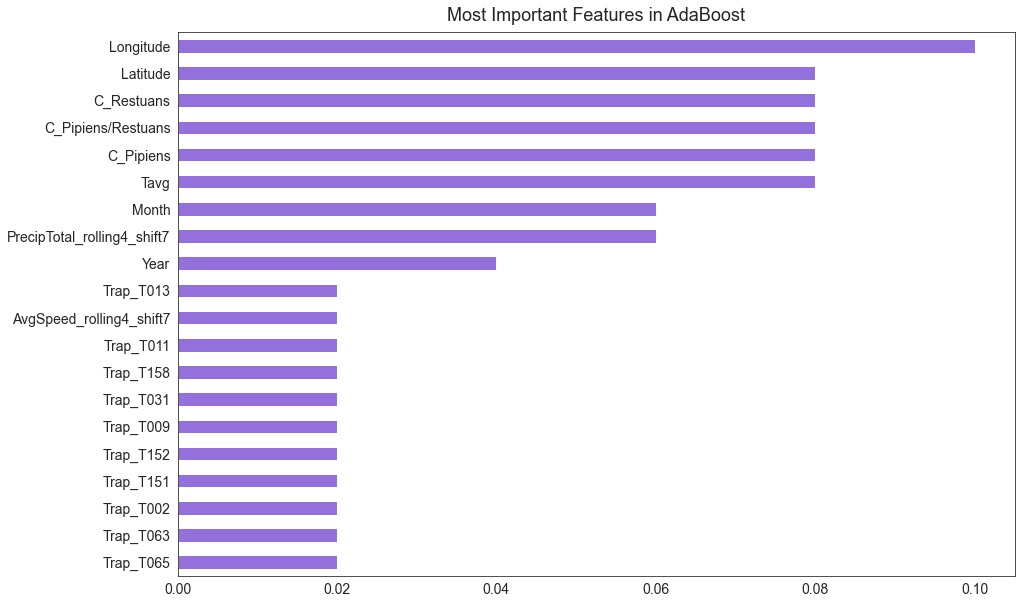

In [64]:
ada_feature_impt_df.sort_values(by='feature importance', ascending=True).tail(20).plot(kind='barh', color='mediumpurple', legend = False, figsize=(15,10));
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Most Important Features in AdaBoost', fontsize=18, y=1.01);

**Longitude, Latitude, Mosquito Species** (Culex Restuans, Culex Pipens/ Restuans, Culex Pipiens), and **Tavg** are the most important features in the AdaBoost model.

## Model 4: Gradient Boost (with SMOTE)

In [65]:
# set up pipeline
pipe_gboost = make_pipeline(SMOTE(random_state=42),
                           GradientBoostingClassifier(random_state=42))

In [66]:
# cross validation score (roc auc)
cross_val_score(pipe_gboost, X_train, y_train, scoring='roc_auc', cv=kf).mean()

0.8341374702731332

In [67]:
pipe_gboost.get_params()

{'memory': None,
 'steps': [('smote', SMOTE(random_state=42)),
  ('gradientboostingclassifier', GradientBoostingClassifier(random_state=42))],
 'verbose': False,
 'smote': SMOTE(random_state=42),
 'gradientboostingclassifier': GradientBoostingClassifier(random_state=42),
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': 42,
 'smote__sampling_strategy': 'auto',
 'gradientboostingclassifier__ccp_alpha': 0.0,
 'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__init': None,
 'gradientboostingclassifier__learning_rate': 0.1,
 'gradientboostingclassifier__loss': 'deviance',
 'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__max_features': None,
 'gradientboostingclassifier__max_leaf_nodes': None,
 'gradientboostingclassifier__min_impurity_decrease': 0.0,
 'gradientboostingclassifier__min_impurity_split': None,
 'gradientboostingclassifier__min_samples_leaf': 1,
 'gradientboostingclassifier__min_samples_split'

In [68]:
# for hyperparameter tuning
pipe_gboost_params = {
    'gradientboostingclassifier__max_depth': [3],             # also tried [2, 4]
    'gradientboostingclassifier__n_estimators': [125],        # also tried [100, 150]
    'gradientboostingclassifier__learning_rate': [0.09]       # also tried [0.1, 0.15]
}

In [69]:
gs_gboost = GridSearchCV(pipe_gboost, param_grid=pipe_gboost_params, cv=kf, 
                         scoring='roc_auc', return_train_score=True)

In [70]:
gs_gboost.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'gradientboostingclassifier__learning_rate': [0.09],
                         'gradientboostingclassifier__max_depth': [3],
                         'gradientboostingclassifier__n_estimators': [125]},
             return_train_score=True, scoring='roc_auc')

In [71]:
gs_gboost.best_params_

{'gradientboostingclassifier__learning_rate': 0.09,
 'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__n_estimators': 125}

In [72]:
gs_gboost.best_score_

0.8365838976288247

In [73]:
gs_gboost_model = gs_gboost.best_estimator_

In [74]:
gs_gboost_y_preds = gs_gboost_model.predict(X_val)

Model           : Gradient Boost
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      1604
           1       0.17      0.65      0.27        91

    accuracy                           0.81      1695
   macro avg       0.57      0.74      0.58      1695
weighted avg       0.93      0.81      0.86      1695

train roc auc      0.84


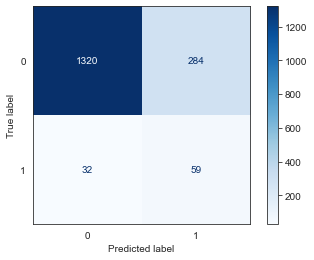

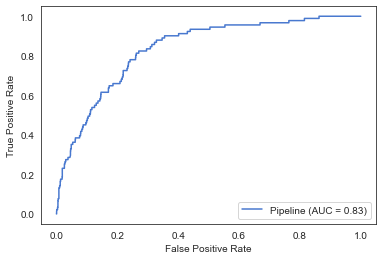

In [75]:
model_eval('Gradient Boost', gs_gboost, X_val, y_val, gs_gboost_y_preds)

Our **GradientBoost (with SMOTE) model** has a **higher Validation ROC AUC of 0.83**. Accuracy is also high at 0.81, but **Sensitivity is low at 0.65**, which again does not meet our modelling objectives.

In [76]:
gboost_feature_impt = gs_gboost_model.named_steps['gradientboostingclassifier'].feature_importances_
gboost_feature_impt_df = pd.DataFrame(index=X_train.columns, data = ada_feature_impt, columns = ['feature importance'])

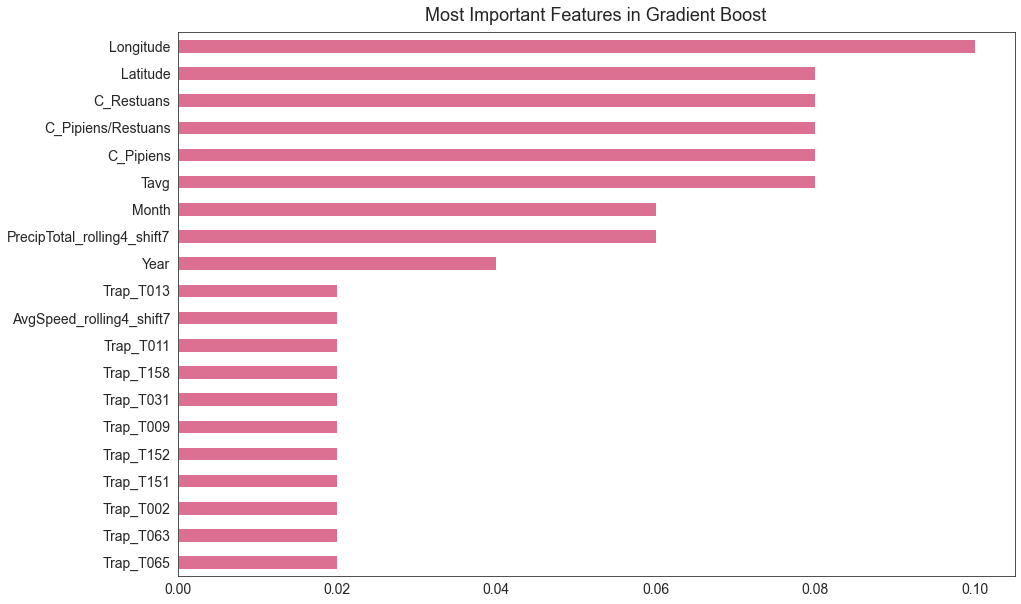

In [77]:
gboost_feature_impt_df.sort_values(by='feature importance', ascending=True).tail(20).plot(kind='barh', color='palevioletred', legend = False, figsize=(15,10));
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Most Important Features in Gradient Boost', fontsize=18, y=1.01);

Similar to the AdaBoost model, **Longitude, Latitude, Mosquito Species** (Culex Restuans, Culex Pipens/ Restuans, Culex Pipiens), and **Tavg** are the most important features in the GradientBoost model.

## Model 5: XGBoost

In XGBoost, the [scale_pos_weight](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/) parameter can help to handle imbalanced class. 

The scale_pos_weight parameter carries a value of 1 to 100. The value to set for the scale_pos_weight hyperparameter is the inverse of the class distribution.

In [78]:
y_train.value_counts(normalize=True)

0    0.946018
1    0.053982
Name: WnvPresent, dtype: float64

Hence, we should set the scale_pos_weight parameter to be 0.946018 * 100 = 94.6018

In [79]:
# set up pipeline
pipe_xgb = make_pipeline(XGBClassifier(random_state=42))

In [80]:
# cross validation score (roc auc)
cross_val_score(pipe_xgb, X_train, y_train, scoring='roc_auc', cv=kf).mean()

0.85233897513715

In [81]:
pipe_xgb.get_params()

{'memory': None,
 'steps': [('xgbclassifier', XGBClassifier(random_state=42))],
 'verbose': False,
 'xgbclassifier': XGBClassifier(random_state=42),
 'xgbclassifier__base_score': 0.5,
 'xgbclassifier__booster': 'gbtree',
 'xgbclassifier__colsample_bylevel': 1,
 'xgbclassifier__colsample_bynode': 1,
 'xgbclassifier__colsample_bytree': 1,
 'xgbclassifier__gamma': 0,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_delta_step': 0,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__min_child_weight': 1,
 'xgbclassifier__missing': None,
 'xgbclassifier__n_estimators': 100,
 'xgbclassifier__n_jobs': 1,
 'xgbclassifier__nthread': None,
 'xgbclassifier__objective': 'binary:logistic',
 'xgbclassifier__random_state': 42,
 'xgbclassifier__reg_alpha': 0,
 'xgbclassifier__reg_lambda': 1,
 'xgbclassifier__scale_pos_weight': 1,
 'xgbclassifier__seed': None,
 'xgbclassifier__silent': None,
 'xgbclassifier__subsample': 1,
 'xgbclassifier__verbosity': 1}

XGBoost has many different [hyperparameters](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) that we can use to tune the model.

In [82]:
# for hyperparameter tuning
pipe_xgb_params = {
    'xgbclassifier__scale_pos_weight': [94.6018],    # to handle imbalanced data
    'xgbclassifier__max_depth': [3],                 # also tried [2, 4]
    'xgbclassifier__n_estimators': [150],            # also tried [100, 200, 250, 300]
    'xgbclassifier__subsample': [0.5],               # also tried [1]
    'xgbclassifier__gamma': [0.5]                    # also tried [0]
}

In [83]:
gs_xgb = GridSearchCV(pipe_xgb, param_grid=pipe_xgb_params, cv=kf, 
                     scoring='roc_auc', return_train_score=True)

In [84]:
gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('xgbclassifier',
                                        XGBClassifier(random_state=42))]),
             param_grid={'xgbclassifier__gamma': [0.5],
                         'xgbclassifier__max_depth': [3],
                         'xgbclassifier__n_estimators': [150],
                         'xgbclassifier__scale_pos_weight': [94.6018],
                         'xgbclassifier__subsample': [0.5]},
             return_train_score=True, scoring='roc_auc')

In [85]:
gs_xgb.best_params_

{'xgbclassifier__gamma': 0.5,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 150,
 'xgbclassifier__scale_pos_weight': 94.6018,
 'xgbclassifier__subsample': 0.5}

In [86]:
gs_xgb.best_score_

0.8484759865520297

In [87]:
gs_xgb_model = gs_xgb.best_estimator_

In [88]:
gs_xgb_y_preds = gs_xgb_model.predict(X_val)

Model           : XGBoost
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.64      0.78      1604
           1       0.12      0.85      0.21        91

    accuracy                           0.65      1695
   macro avg       0.55      0.74      0.49      1695
weighted avg       0.94      0.65      0.74      1695

train roc auc      0.85


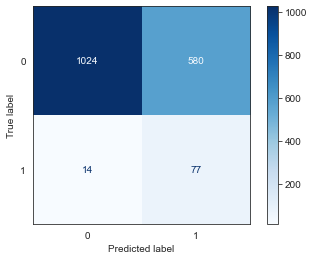

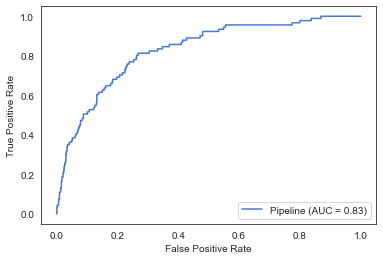

In [89]:
model_eval('XGBoost', gs_xgb, X_val, y_val, gs_xgb_y_preds)

For the **XGBoost model**, the **Validation ROC AUC is 0.83, comparable to GradientBoost**. However, **Sensitivity is notably higher at 0.85**, while accuracy is lower 0.65.

Based on our modelling objectives (high ROC AUC and Sensitivity), **XGBoost is the best model**.

In [90]:
xgb_feature_impt = gs_xgb_model.named_steps['xgbclassifier'].feature_importances_
xgb_feature_impt_df = pd.DataFrame(index=X_train.columns, data = xgb_feature_impt, columns = ['feature importance'])

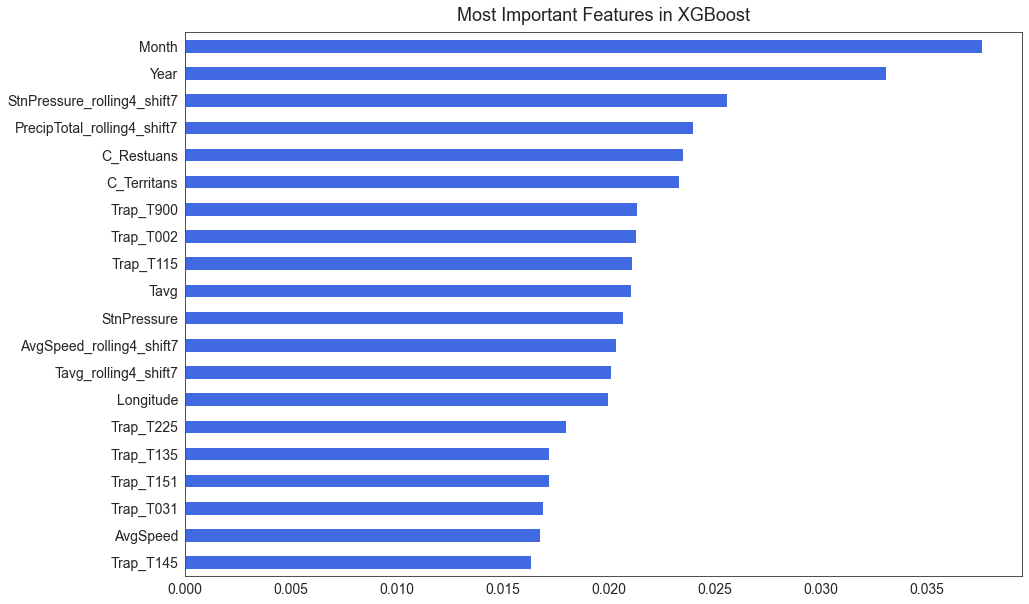

In [91]:
xgb_feature_impt_df.sort_values(by='feature importance', ascending=True).tail(20).plot(kind='barh', color='royalblue', legend = False, figsize=(15,10));
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Most Important Features in XGBoost', fontsize=18, y=1.01);

For this model, **Month and Year** came up as the most important features, followed by **StnPressure and PrecipTotal in the breeding window period (T-7 to T-10 days)**, and the **Mosquito Species**.

Notably, **Trap number T900, T002 and T115** also stand out as key features. These traps correspond to those **hotzones with high number of mosquito and instances of WnvPresent** based on our EDA.

# 5. Model Evaluation

|      | Logistic Regression | Random Forest | AdaBoost | Gradient Boost | XGBoost |
|:---  |:---: |:---: |:---: |:---: |:---: |
| Train ROC AUC | 0.78 | 0.83 | 0.81 | 0.84 | 0.85 |
| Validation ROC AUC | 0.80 | 0.81 | 0.80 | 0.83 | 0.83 |
| Sensitivity | 0.68 | 0.77 | 0.56 | 0.65 | 0.85 |
| Accuracy | 0.77 | 0.75 | 0.81 | 0.81 | 0.65 |

Comparing the 5 models, **XGBoost** performs the **best in terms of both ROC AUC and Sensitivity**.

# 6. Generate Predictions

In [92]:
X_test = test[[col for col in test.columns if col != 'Id']]

In [93]:
X_test.shape

(116293, 154)

In [94]:
X_train.shape

(6780, 154)

In [95]:
y_preds_xgb = gs_xgb_model.predict_proba(X_test)

In [96]:
y_preds_xgb

array([[0.8459856 , 0.15401441],
       [0.953474  , 0.04652601],
       [0.8568047 , 0.14319529],
       ...,
       [0.9418038 , 0.05819616],
       [0.9418038 , 0.05819616],
       [0.9418038 , 0.05819616]], dtype=float32)

In [98]:
submission_xgb = pd.DataFrame(test['Id'])
submission_xgb['WnvPresent'] = y_preds_xgb[:,1]

In [99]:
submission_xgb.to_csv('./data/kaggle_submission.csv', index=False)

**Kaggle public score (Test ROC AUC): 0.77363**

# 7. Cost Benefit Analysis

As part of the Data Science team at the Disease and Treatment Agency, we have been tasked by the Centers for Disease Control (CDC) to develop a strategy to deploy the effective use of pesticides, by targeting spraying of pesticides to areas of high risk will help to mitigate future outbreaks.

The team further did external research on the effective use of pesticides and we will refer to the article on [Economic Cost Analysis of West Nile Virus Outbreak, Sacramento County, California, USA, 2005](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/#R6) as benchmark of effective spraying, and we will refer to 
[Economic Burden of West Nile Virus in the United States](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3945680/) for the medical cost of treating West Nile Virus patients, particularly Neuroinvasive diseases.

The team conducted 3 Scenarios of the Cost Benefit Analysis as follows:

![title](image/cost_benefit_summary.png)


*Details in the file [P4_3_Cost_Benefit_Analysis.xlsx](P4_3_Cost_Benefit_Analysis.xlsx)


# 8. Conclusion & Recommendation

Model 5 based on XGBoost Classifier is the best model to address our problem statement as it has the highest scores on both ROC AUC (0.83) and Sensitivity (0.85), generating the predictions that maximizes True Positive and minimizes False Negative (incorrectly predicting absence of virus).

Based on this model, the most important factors for predicting presence of West Nile Virus are as follows:
1. **Seasonality** (Month and Year)
2. **Time** (Pressure and Precipitation - with feature engineering to capture mosquito breeding period by rolling average of 7-10 days)
3. **Mosquito Species** (C_Restuans and C_Territans)
4. **Hotspots** (Traps: T900, T002, and T115)


Our model has ROC AUC (kaggle score) of 0.77 on completely unseen data. 

In our cost benefit analysis, the most cost effective scenario is **Targeted Spraying** the top 5 mosquito hotzones for 6 times during peak period (Jul-Aug).  
